# OpenSMILE Analysis
This notebook loads OpenSMILE csv- data, cleans and plots it

## Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import itertools as it
from statsmodels.sandbox.stats.multicomp import multipletests
#import nltk
import scipy.stats as st

import seaborn as sns
import Helper as hp

## Load .csv data with results of OpenSMILE Analysis
First we load .csv data and clean it (removing of NaNs), then we store information of all files in seperate panda dataframes containing information about affect, emotion and valence/arousal for all participants.

In [2]:
# Get Filenames to iterate
filenames = listdir('OpenSMILE_Data')

#Create python lists which store results
arousal = []
valence = []
emotion = []
affect = []
loi = []
characterIDs = []

fnames = []
filenames.sort()
for x in filenames:
    fnames.append([x])    
    
emotion_label = ['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']
affect_label = ['aggressiv', 'cheerful', 'intoxicated', 'nervous', 'neutral', 'tired']
loi_label = ['disinterest', 'normal', 'high interest']

for i in range(len(fnames)):
     # data contains all information (arousal, valence, emotion, affect) and we want to save the values of all files in a list
    data = pd.read_csv("OpenSMILE_Data/" + filenames[i])    

    # For arousal, valence and affect we have to drop nans, since they have less values than emotion
    temp_arousal = data['arousal']
    temp_arousal = temp_arousal.dropna()
    temp_valence = data['valence'] 
    temp_valence = temp_valence.dropna()
    temp_affect = data['abcAffect']
    temp_affect = temp_affect.dropna()
    temp_emotion = data['emodbEmotion']
    temp_loi = data['avicLoI']
    temp_loi = temp_loi.dropna()
    characterIDs.append(fnames[i][0][0])
    
    #Append the temp values to 'global lists'
    emotion.append(temp_emotion.values.tolist())
    affect.append(temp_affect.values.tolist())
    valence.append(temp_valence.values)
    arousal.append(temp_arousal.values)
    loi.append(temp_loi.values)

#We want to have the labels as column seperators and the filenames as ID 
#We want to do this, so that if we add more files (at the moment only 6 .csv files are loaded) we want to add rows and not columns
#If we plot the data, emotion_label can be used as label
df_emotion = pd.DataFrame.from_records(emotion)
df_emotion.columns = emotion_label
df_emotion['CharacterID'] = characterIDs
df_emotion['file'] = filenames

#Now do the same for affect
df_affect = pd.DataFrame.from_records(affect)
df_affect.columns = affect_label
df_affect['CharacterID'] = characterIDs
df_affect['file'] = filenames

#Now for loi
df_loi = pd.DataFrame.from_records(loi)
df_loi.columns = loi_label
df_loi['CharacterID'] = characterIDs
df_loi['file'] = filenames

#For Arousal and Valence, we want to combine these two features so that we can draw a scatter plot in the arousal valence space
np_ar = np.array(arousal).ravel()
np_val = np.array(valence).ravel()
np_ar_val = np.array([np_ar, np_val])

#Transpose Matrix so that it is in the same form as affect and emotion (columns = arousal, valence, ID = Filename)
df_ar_val = pd.DataFrame.from_records(np_ar_val.T)
#df_ar_val.index = filenames
df_ar_val.columns = ['valence', 'arousal']
df_ar_val['CharacterID'] = characterIDs
df_ar_val['file'] = filenames


## Now that we have our Panda Dataframes we can go ahead and have a look at the data by plotting it

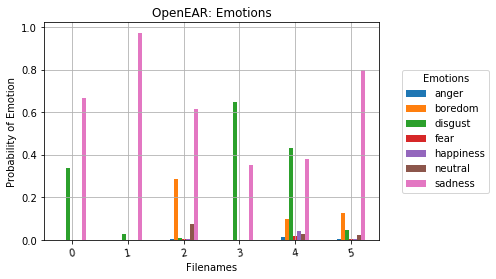

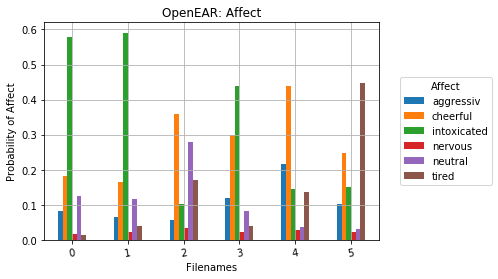

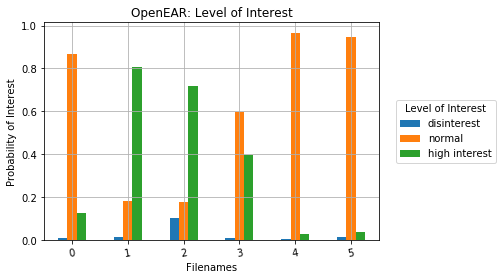

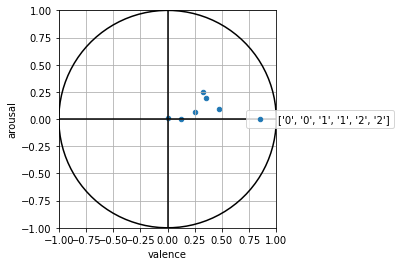

In [3]:
# Start with Emotion
ax_emo = df_emotion.plot.bar(title = 'OpenEAR: Emotions', rot = 10) #We set rotation to 10 so that the filenames can be read
ax_emo.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Emotions')
ax_emo.set_ylabel('Probability of Emotion')
ax_emo.set_xlabel('Filenames')
plt.grid(True)

#Same for Affect
ax_aff = df_affect.plot.bar(title = 'OpenEAR: Affect', rot = 10)
ax_aff.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Affect')
ax_aff.set_ylabel('Probability of Affect')
ax_aff.set_xlabel('Filenames')
plt.grid(True)

#And same for Level of Interest
ax_loi = df_loi.plot.bar(title = 'OpenEAR: Level of Interest', rot = 10)
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Level of Interest')
ax_loi.set_ylabel('Probability of Interest')
ax_loi.set_xlabel('Filenames')
plt.grid(True)

#Now plot Arousal-Valence data in arousal valence space

#Try to get the legen to display the filenames (Not working yet)
fnames = []
for x in filenames:
    fnames.append([x])
    
ax_ar_val = df_ar_val.plot.scatter(x = 'valence', y = 'arousal', label = characterIDs)

#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax_ar_val.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax_ar_val.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax_ar_val.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax_ar_val.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
ax_ar_val.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

## Let's load information about the speakers
The speaker ID is saved in a single .csv file containing four important columns: ID, Age, Sex and Acadedmic Status. Since before loaded OpenSMILE csv files are named using the corresponding index (ex. speaker with id 0 has two files 0_a.csv and 0_b.csv), so that a link can be created

In [4]:
char_data = pd.read_csv("CharacterData/CharacterIDs.csv")    

#Join above tables and Character Tables

#To Join DataFrames we have to cast the column on which we want to join to int, so that both columns have the same data type
char_data['CharacterID'] = char_data['CharacterID'].astype(int)
df_ar_val['CharacterID'] = df_ar_val['CharacterID'].astype(int)
df_emotion['CharacterID'] = df_emotion['CharacterID'].astype(int)
df_affect['CharacterID'] = df_affect['CharacterID'].astype(int)
df_loi['CharacterID'] = df_loi['CharacterID'].astype(int)

#Safe new data frames
df_ar_val_char = df_ar_val.merge(char_data, how = 'left', left_on='CharacterID', right_on='CharacterID')
df_emotion_char = df_emotion.merge(char_data, how = 'left', left_on='CharacterID', right_on= 'CharacterID')
df_affect_char = df_affect.merge(char_data, how = 'left', left_on='CharacterID', right_on= 'CharacterID')
df_loi_char = df_loi.merge(char_data, how = 'left', left_on='CharacterID', right_on= 'CharacterID')

## Now let's have another look at the plots using the character data
### Let's take a look at female/male

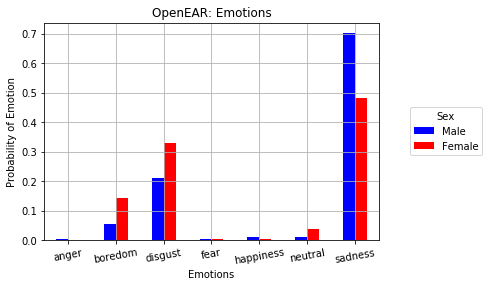

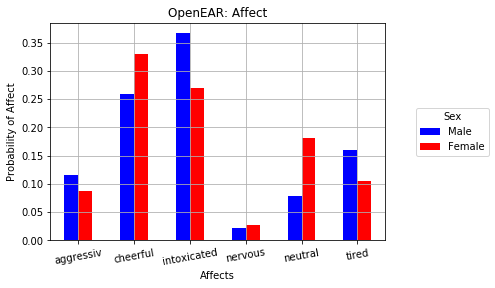

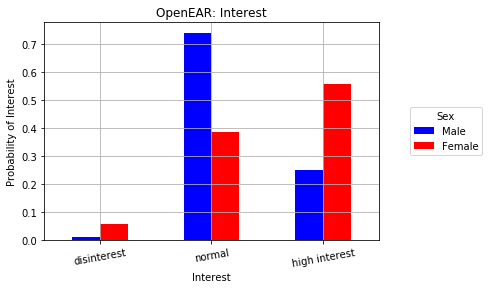

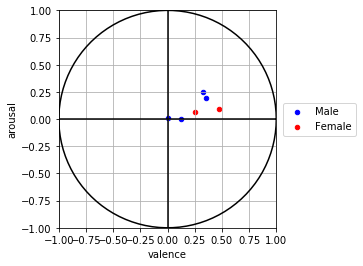

In [5]:
df_ar_val_male = df_ar_val_char.loc[df_ar_val_char['Sex'] == 0]
df_ar_val_female = df_ar_val_char.loc[df_ar_val_char['Sex'] == 1]

df_emotion_char_male = df_emotion_char.loc[df_emotion_char['Sex'] == 0]
df_emotion_char_female = df_emotion_char.loc[df_emotion_char['Sex'] == 1]

df_affect_char_male = df_affect_char.loc[df_affect_char['Sex'] == 0]
df_affect_char_female = df_affect_char.loc[df_affect_char['Sex'] == 1]

df_loi_char_male = df_loi_char.loc[df_loi_char['Sex'] == 0]
df_loi_char_female = df_loi_char.loc[df_loi_char['Sex'] == 1]

#For Plotting, lets calculate the mean emotion value for all audiofiles
df_emotion_char_male = df_emotion_char_male.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_emotion_char_male = df_emotion_char_male.mean()
df_emotion_char_female = df_emotion_char_female.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_emotion_char_female = df_emotion_char_female.mean()
df_emo_sex = pd.DataFrame({'Male': df_emotion_char_male, 'Female': df_emotion_char_female}, index = emotion_label)

#And do the same for affect
df_affect_char_male = df_affect_char_male.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_affect_char_male = df_affect_char_male.mean()
df_affect_char_female = df_affect_char_female.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_affect_char_female = df_affect_char_female.mean()
df_aff_sex = pd.DataFrame({'Male': df_affect_char_male, 'Female': df_affect_char_female}, index = affect_label)

#And for Level of Interest
df_loi_char_male = df_loi_char_male.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_loi_char_male = df_loi_char_male.mean()
df_loi_char_female = df_loi_char_female.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_loi_char_female = df_loi_char_female.mean()
df_loi_sex = pd.DataFrame({'Male': df_loi_char_male, 'Female': df_loi_char_female}, index = loi_label)

# Start with Emotion
ax_emo = df_emo_sex.plot.bar(title = 'OpenEAR: Emotions',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_emo.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_emo.set_ylabel('Probability of Emotion')
ax_emo.set_xlabel('Emotions')
plt.grid(True)

#Now let's plot affect bar diagram
ax_aff = df_aff_sex.plot.bar(title = 'OpenEAR: Affect',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_aff.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_aff.set_ylabel('Probability of Affect')
ax_aff.set_xlabel('Affects')
plt.grid(True)

#Now Level of Interest
ax_loi = df_loi_sex.plot.bar(title = 'OpenEAR: Interest',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_loi.set_ylabel('Probability of Interest')
ax_loi.set_xlabel('Interest')
plt.grid(True)

#And finally arousal valence
ax1 = df_ar_val_male.plot.scatter(x = 'valence', y = 'arousal', label = 'Male', c = 'b')
ax2 = df_ar_val_female.plot.scatter(x = 'valence', y = 'arousal', label = 'Female', c = 'r', ax=ax1)
#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax1.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax1.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax1.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax1.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
ax1.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

### Let's have look at academic status
Bachelor and Master will be replaced with the to the video corresponding academic status

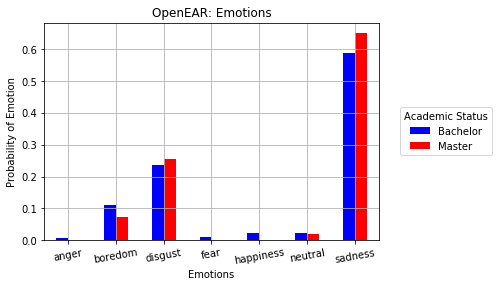

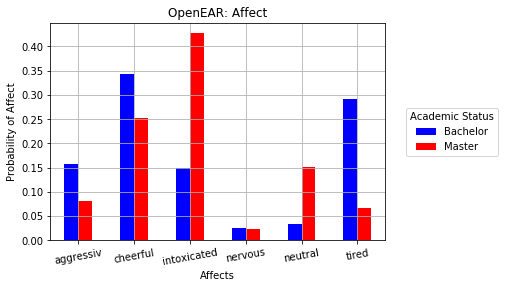

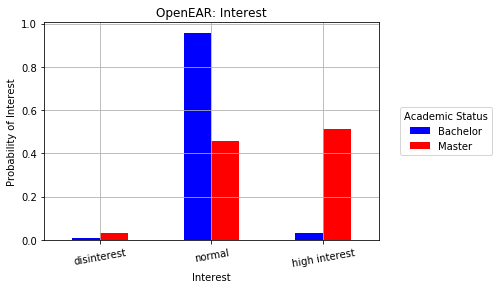

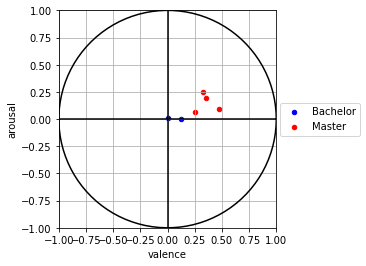

In [6]:
df_ar_val_bachelor = df_ar_val_char.loc[df_ar_val_char['Academic Status'] == 0]
df_ar_val_master = df_ar_val_char.loc[df_ar_val_char['Academic Status'] == 1]

df_emotion_bachelor= df_emotion_char.loc[df_emotion_char['Academic Status'] == 0]
df_emotion_master = df_emotion_char.loc[df_emotion_char['Academic Status'] == 1]

df_affect_bachelor = df_affect_char.loc[df_affect_char['Academic Status'] == 0]
df_affect_master = df_affect_char.loc[df_affect_char['Academic Status'] == 1]

df_loi_bachelor = df_loi_char.loc[df_loi_char['Academic Status'] == 0]
df_loi_master = df_loi_char.loc[df_loi_char['Academic Status'] == 1]

#For Plotting, lets calculate the mean emotion value for all audiofiles
df_emotion_bachelor = df_emotion_bachelor.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_emotion_bachelor = df_emotion_bachelor.mean()
df_emotion_master = df_emotion_master.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_emotion_master = df_emotion_master.mean()
df_emo_aca = pd.DataFrame({'Bachelor': df_emotion_bachelor, 'Master': df_emotion_master}, index = emotion_label)

#And do the same for affect
df_affect_bachelor = df_affect_bachelor.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_affect_bachelor = df_affect_bachelor.mean()
df_affect_master = df_affect_master.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_affect_master = df_affect_master.mean()
df_aff_aca = pd.DataFrame({'Bachelor': df_affect_bachelor, 'Master': df_affect_master}, index = affect_label)

#And now for LoI
df_loi_bachelor = df_loi_bachelor.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_loi_bachelor = df_loi_bachelor.mean()
df_loi_master = df_loi_master.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_loi_master = df_loi_master.mean()
df_loi_aca = pd.DataFrame({'Bachelor': df_loi_bachelor, 'Master': df_loi_master}, index = loi_label)

# Start with Emotion
ax_emo1 = df_emo_aca.plot.bar(title = 'OpenEAR: Emotions',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_emo1.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Academic Status')
ax_emo1.set_ylabel('Probability of Emotion')
ax_emo1.set_xlabel('Emotions')
plt.grid(True)

#Now let's plot affect bar diagram
ax_aff1 = df_aff_aca.plot.bar(title = 'OpenEAR: Affect',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_aff1.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Academic Status')
ax_aff1.set_ylabel('Probability of Affect')
ax_aff1.set_xlabel('Affects')
plt.grid(True)

#Now plot LoI diagram
ax_loi = df_loi_aca.plot.bar(title = 'OpenEAR: Interest',rot = 10, color = ['b','r']) #We set rotation to 10 so that the filenames can be read
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Academic Status')
ax_loi.set_ylabel('Probability of Interest')
ax_loi.set_xlabel('Interest')
plt.grid(True)

ax11 = df_ar_val_bachelor.plot.scatter(x = 'valence', y = 'arousal', label = 'Bachelor', c = 'b')
ax21 = df_ar_val_master.plot.scatter(x = 'valence', y = 'arousal', label = 'Master', c = 'r', ax=ax11)
#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax11.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax11.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax11.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax11.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
ax11.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

### Lastly take a look at age
What's now 23,24 and 25 will be replaced by young, middle and old , the age thresholds will be calculated so that each group is distributed

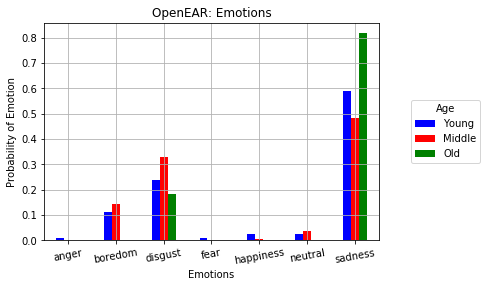

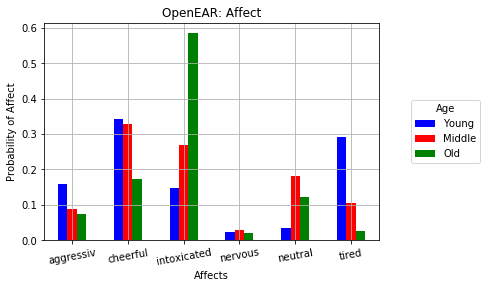

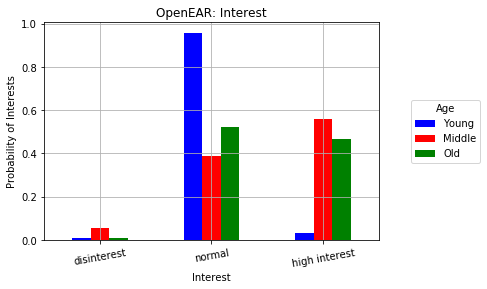

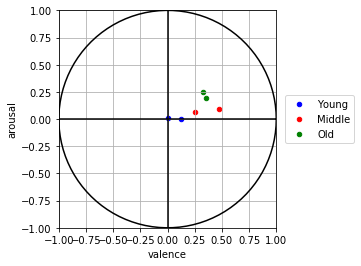

In [7]:
df_ar_val_young = df_ar_val_char.loc[df_ar_val_char['Age'] == 23]
df_ar_val_middle = df_ar_val_char.loc[df_ar_val_char['Age'] == 24]
df_ar_val_old = df_ar_val_char.loc[df_ar_val_char['Age'] == 25]

df_emotion_young= df_emotion_char.loc[df_emotion_char['Age'] == 23]
df_emotion_middle = df_emotion_char.loc[df_emotion_char['Age'] == 24]
df_emotion_old = df_emotion_char.loc[df_emotion_char['Age'] == 25]

df_affect_young = df_affect_char.loc[df_affect_char['Age'] == 23]
df_affect_middle = df_affect_char.loc[df_affect_char['Age'] == 24]
df_affect_old = df_affect_char.loc[df_affect_char['Age'] == 25]

df_loi_young = df_loi_char.loc[df_loi_char['Age'] == 23]
df_loi_middle = df_loi_char.loc[df_loi_char['Age'] == 24]
df_loi_old = df_loi_char.loc[df_loi_char['Age'] == 25]

#For Plotting, lets calculate the mean emotion value for all audiofiles
df_emotion_young = df_emotion_young.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_emotion_young = df_emotion_young.mean()
df_emotion_middle = df_emotion_middle.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_emotion_middle = df_emotion_middle.mean()
df_emotion_old = df_emotion_old.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_emotion_old = df_emotion_old.mean()
df_emo_age = pd.DataFrame({'Young': df_emotion_young, 'Middle': df_emotion_middle, 'Old': df_emotion_old}, index = emotion_label)

#And do the same for affect
df_affect_young = df_affect_young.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_affect_young = df_affect_young.mean()
df_affect_middle = df_affect_middle.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_affect_middle = df_affect_middle.mean()
df_affect_old = df_affect_old.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_affect_old = df_affect_old.mean()
df_aff_age = pd.DataFrame({'Young': df_affect_young, 'Middle': df_affect_middle, 'Old': df_affect_old}, index = affect_label)

#And for LoI
df_loi_young = df_loi_young.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_loi_young = df_loi_young.mean()
df_loi_middle = df_loi_middle.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_loi_middle = df_loi_middle.mean()
df_loi_old = df_loi_old.drop(['CharacterID','file', 'Age', 'Sex', 'Academic Status'], axis = 1)
df_loi_old = df_loi_old.mean()
df_loi_age = pd.DataFrame({'Young': df_loi_young, 'Middle': df_loi_middle, 'Old': df_loi_old}, index = loi_label)

# Start Plotting Emotion
ax_emo2 = df_emo_age.plot.bar(title = 'OpenEAR: Emotions',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_emo2.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Age')
ax_emo2.set_ylabel('Probability of Emotion')
ax_emo2.set_xlabel('Emotions')
plt.grid(True)

#Now let's plot affect bar diagram
ax_aff2 = df_aff_age.plot.bar(title = 'OpenEAR: Affect',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_aff2.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Age')
ax_aff2.set_ylabel('Probability of Affect')
ax_aff2.set_xlabel('Affects')
plt.grid(True)

#And Level of Interest
ax_loi = df_loi_age.plot.bar(title = 'OpenEAR: Interest',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Age')
ax_loi.set_ylabel('Probability of Interests')
ax_loi.set_xlabel('Interest')
plt.grid(True)

ax200 = df_ar_val_young.plot.scatter(x = 'valence', y = 'arousal', label = 'Young', c = 'b')
ax201 = df_ar_val_middle.plot.scatter(x = 'valence', y = 'arousal', label = 'Middle', c = 'r', ax=ax200)
ax202 = df_ar_val_old.plot.scatter(x = 'valence', y = 'arousal', label = 'Old', c = 'g', ax=ax200)
#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax200.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax200.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax200.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax200.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
ax200.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

## Distribution Plots
We want to take a look at the distribution of our emotions, affects, level of interest and arousal-valence. So, every emotion, e.g. anger is plotted using seaborns kdeplot().

For Arousal-Valence, we'll use jointplot(kind = "kde")

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


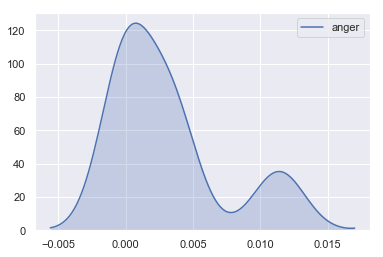

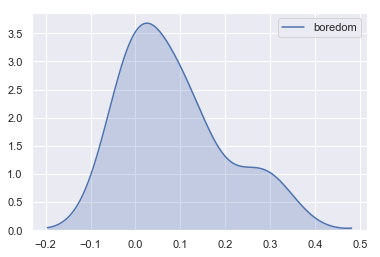

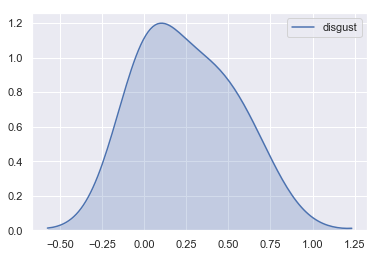

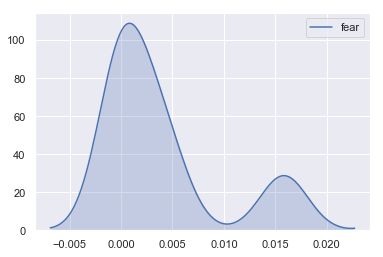

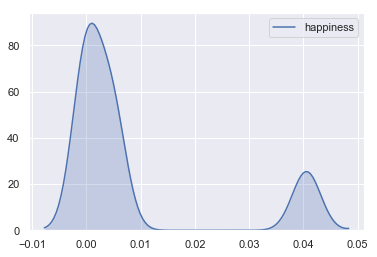

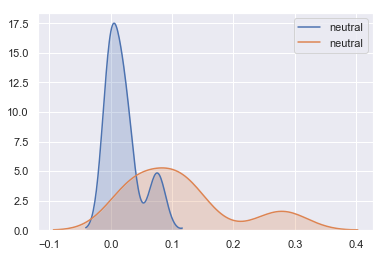

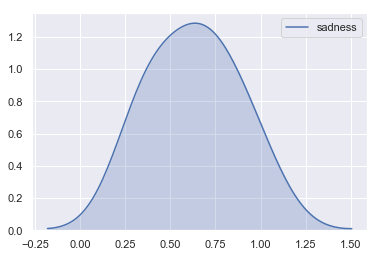

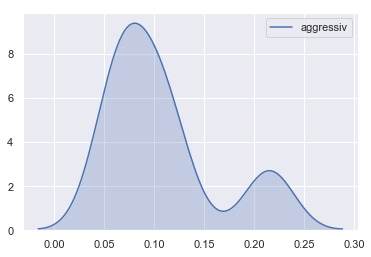

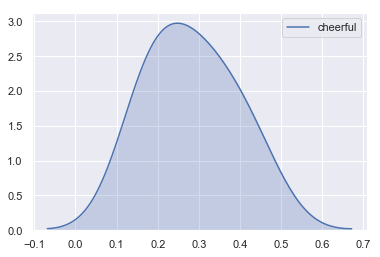

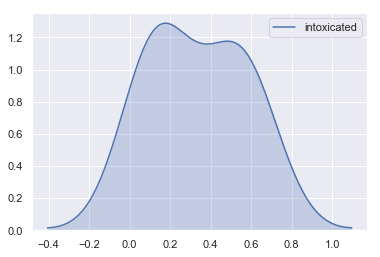

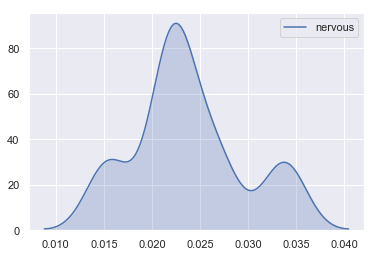

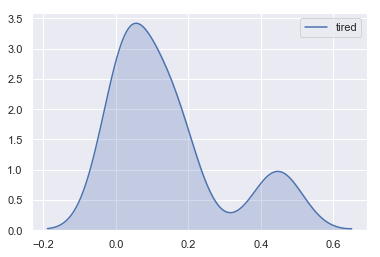

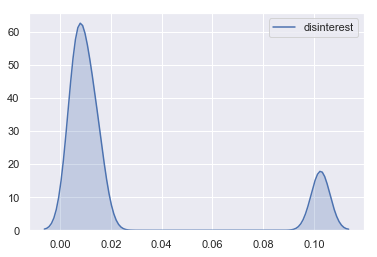

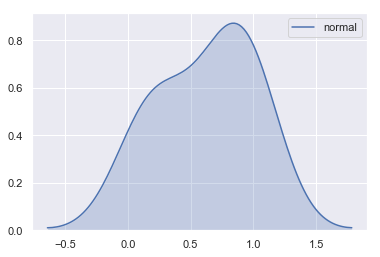

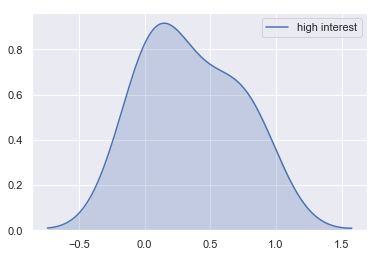

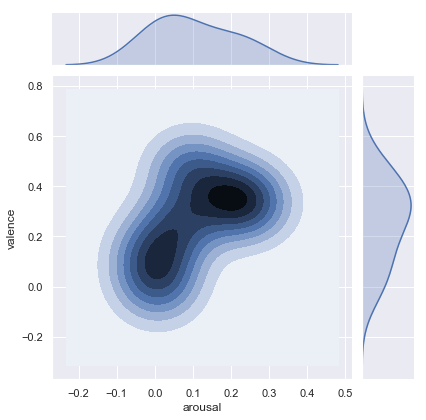

In [8]:
sns.set()
hp.distPlots(df_emotion, emotion_label)
hp.distPlots(df_affect, affect_label)
hp.distPlots(df_loi, loi_label)
df_dis_ar_val_sex = df_ar_val_char.drop(['CharacterID','file', 'Age', 'Academic Status'], axis = 1)
sns.jointplot(x = "arousal", y = "valence", data = df_ar_val, kind = "kde")

## Swarm Plots of categorical data in relation to characteristic features
### Starting with Sex

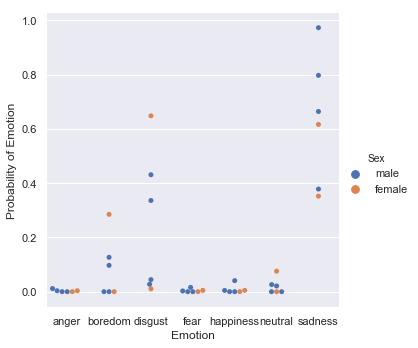

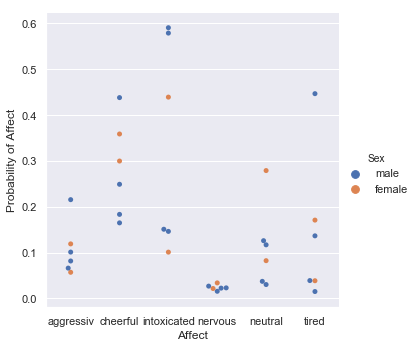

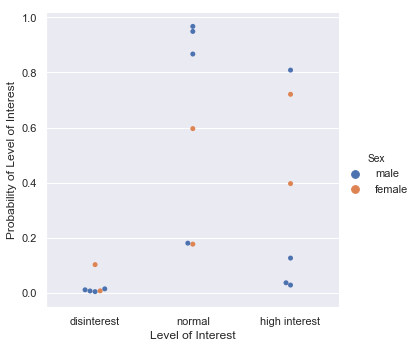

In [9]:
#Start plotting distribution of categorical data with seaborn
#e.g. emotions and sex

df_dis_emotion_sex = df_emotion_char.drop(['CharacterID','file', 'Age', 'Academic Status'], axis = 1)
hp.catPlot(df_dis_emotion_sex, 'Emotion', 'Sex', 'swarm')
df_dis_affect_sex = df_affect_char.drop(['CharacterID','file', 'Age', 'Academic Status'], axis = 1)
hp.catPlot(df_dis_affect_sex, 'Affect', 'Sex', 'swarm')
df_dis_loi_sex = df_loi_char.drop(['CharacterID','file', 'Age', 'Academic Status'], axis = 1)
hp.catPlot(df_dis_loi_sex, 'Level of Interest', 'Sex', 'swarm')

### Now Academic Status

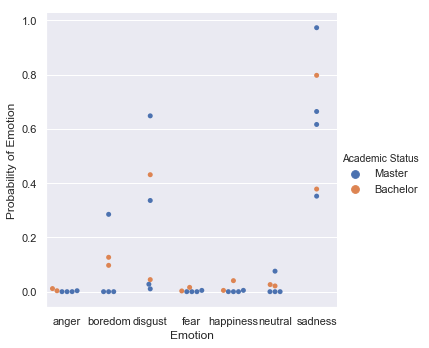

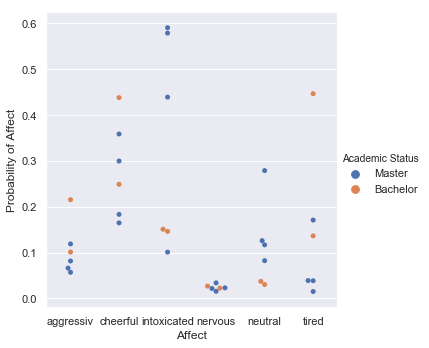

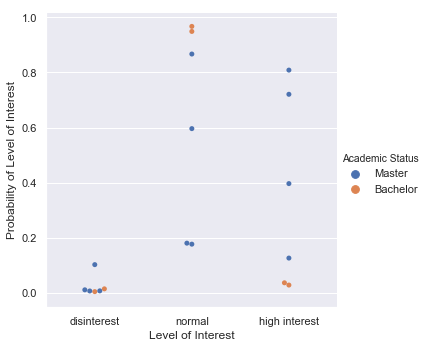

In [10]:
df_dis_emotion_aca = df_emotion_char.drop(['CharacterID','file', 'Age', 'Sex'], axis = 1)
hp.catPlot(df_dis_emotion_aca, 'Emotion', 'Academic Status', 'swarm')
df_dis_affect_aca = df_affect_char.drop(['CharacterID','file', 'Age', 'Sex'], axis = 1)
hp.catPlot(df_dis_affect_aca, 'Affect', 'Academic Status', 'swarm')
df_dis_loi_aca = df_loi_char.drop(['CharacterID','file', 'Age', 'Sex'], axis = 1)
hp.catPlot(df_dis_loi_aca, 'Level of Interest', 'Academic Status', 'swarm')

### Now Age

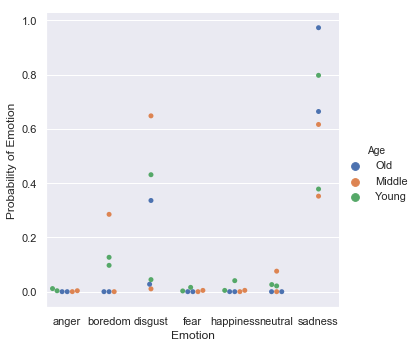

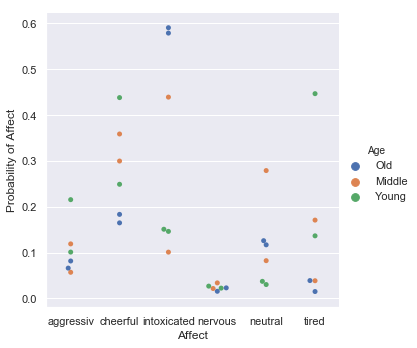

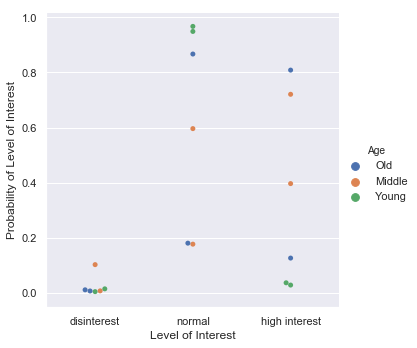

In [11]:
df_dis_emotion_age = df_emotion_char.drop(['CharacterID','file', 'Academic Status', 'Sex'], axis = 1)
hp.catPlot(df_dis_emotion_age, 'Emotion', 'Age', 'swarm')
df_dis_affect_age = df_affect_char.drop(['CharacterID','file', 'Academic Status', 'Sex'], axis = 1)
hp.catPlot(df_dis_affect_age, 'Affect', 'Age', 'swarm')
df_dis_loi_age = df_loi_char.drop(['CharacterID','file', 'Academic Status', 'Sex'], axis = 1)
hp.catPlot(df_dis_loi_age, 'Level of Interest', 'Age', 'swarm')

## Pairplots
### Starting with Emotions and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


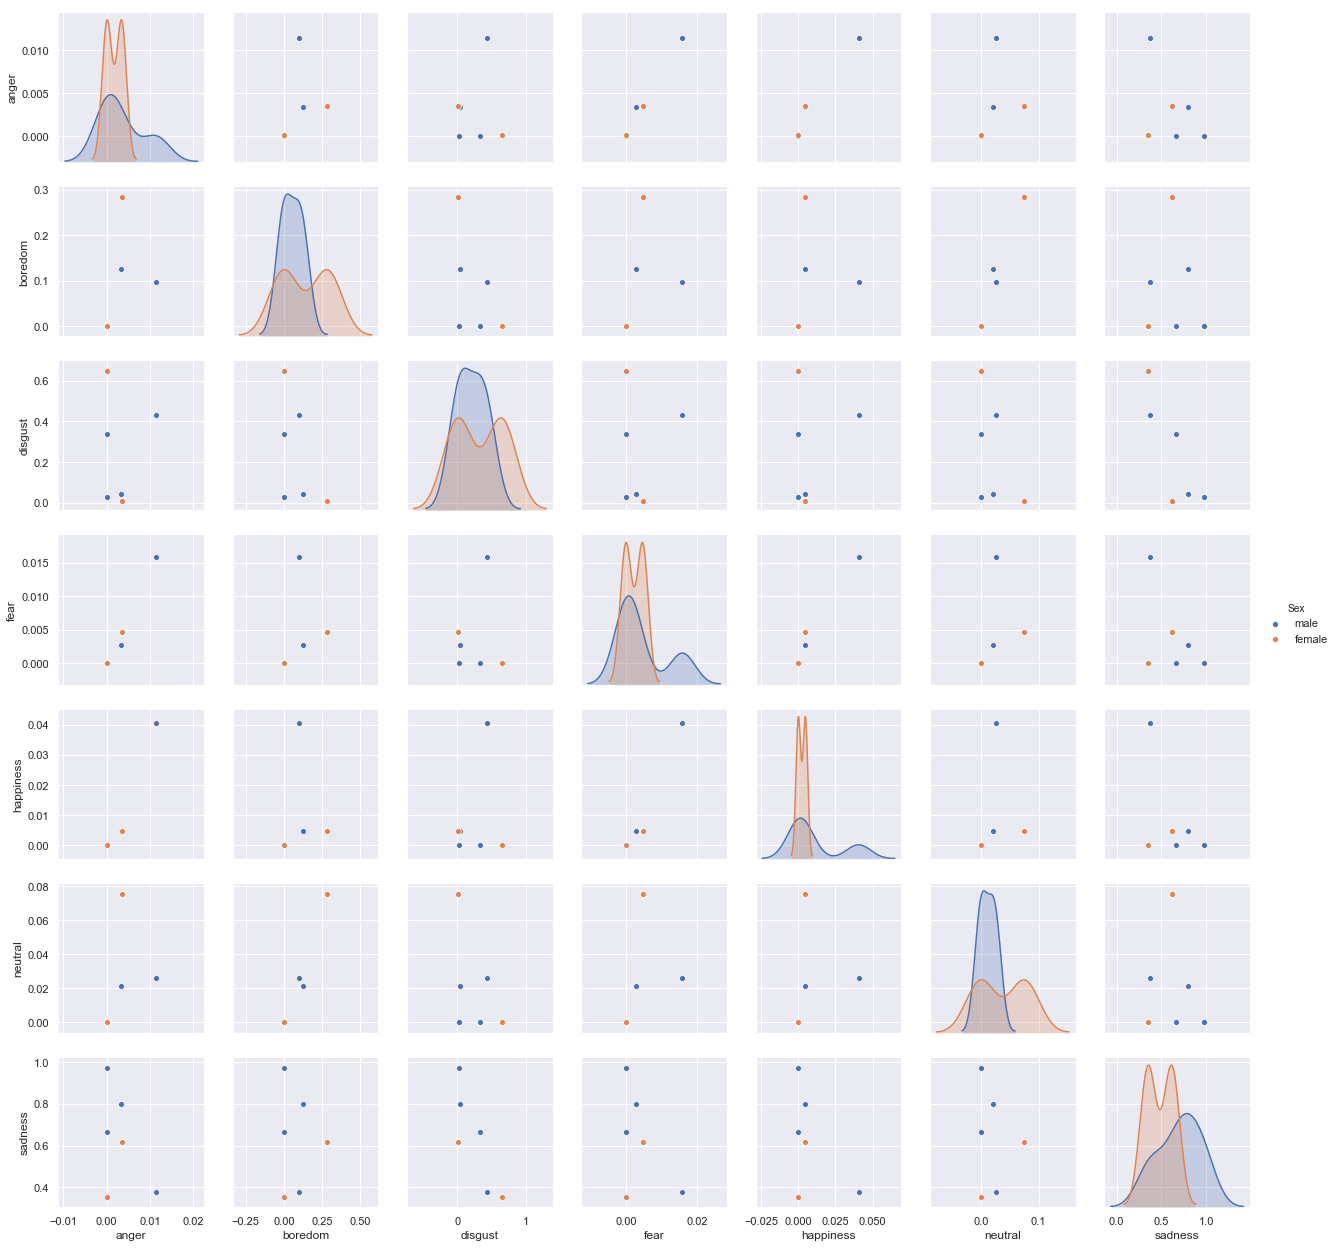

In [12]:
sns.pairplot(df_dis_emotion_sex, hue = "Sex")

### Affect and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


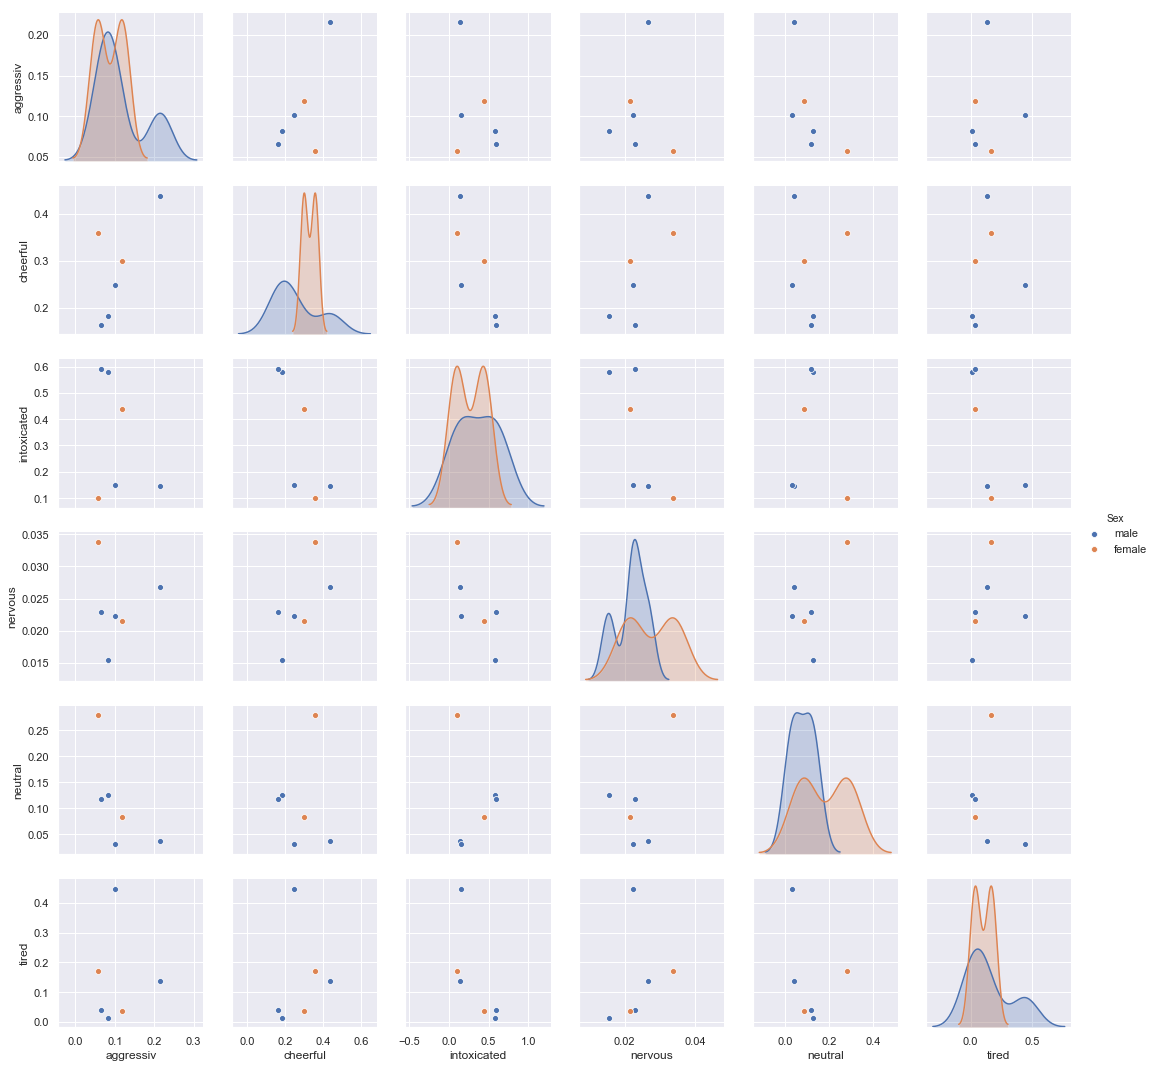

In [13]:
sns.pairplot(df_dis_affect_sex, hue = "Sex")

### Level of Interest and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


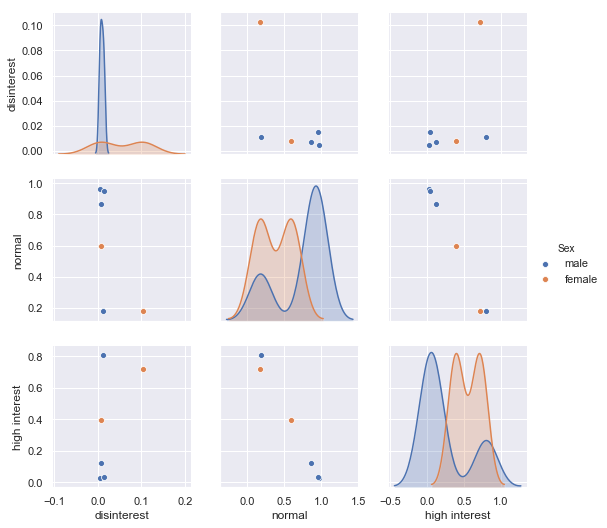

In [14]:
sns.pairplot(df_dis_loi_sex, hue = "Sex")

### Emotions and Academic Status

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


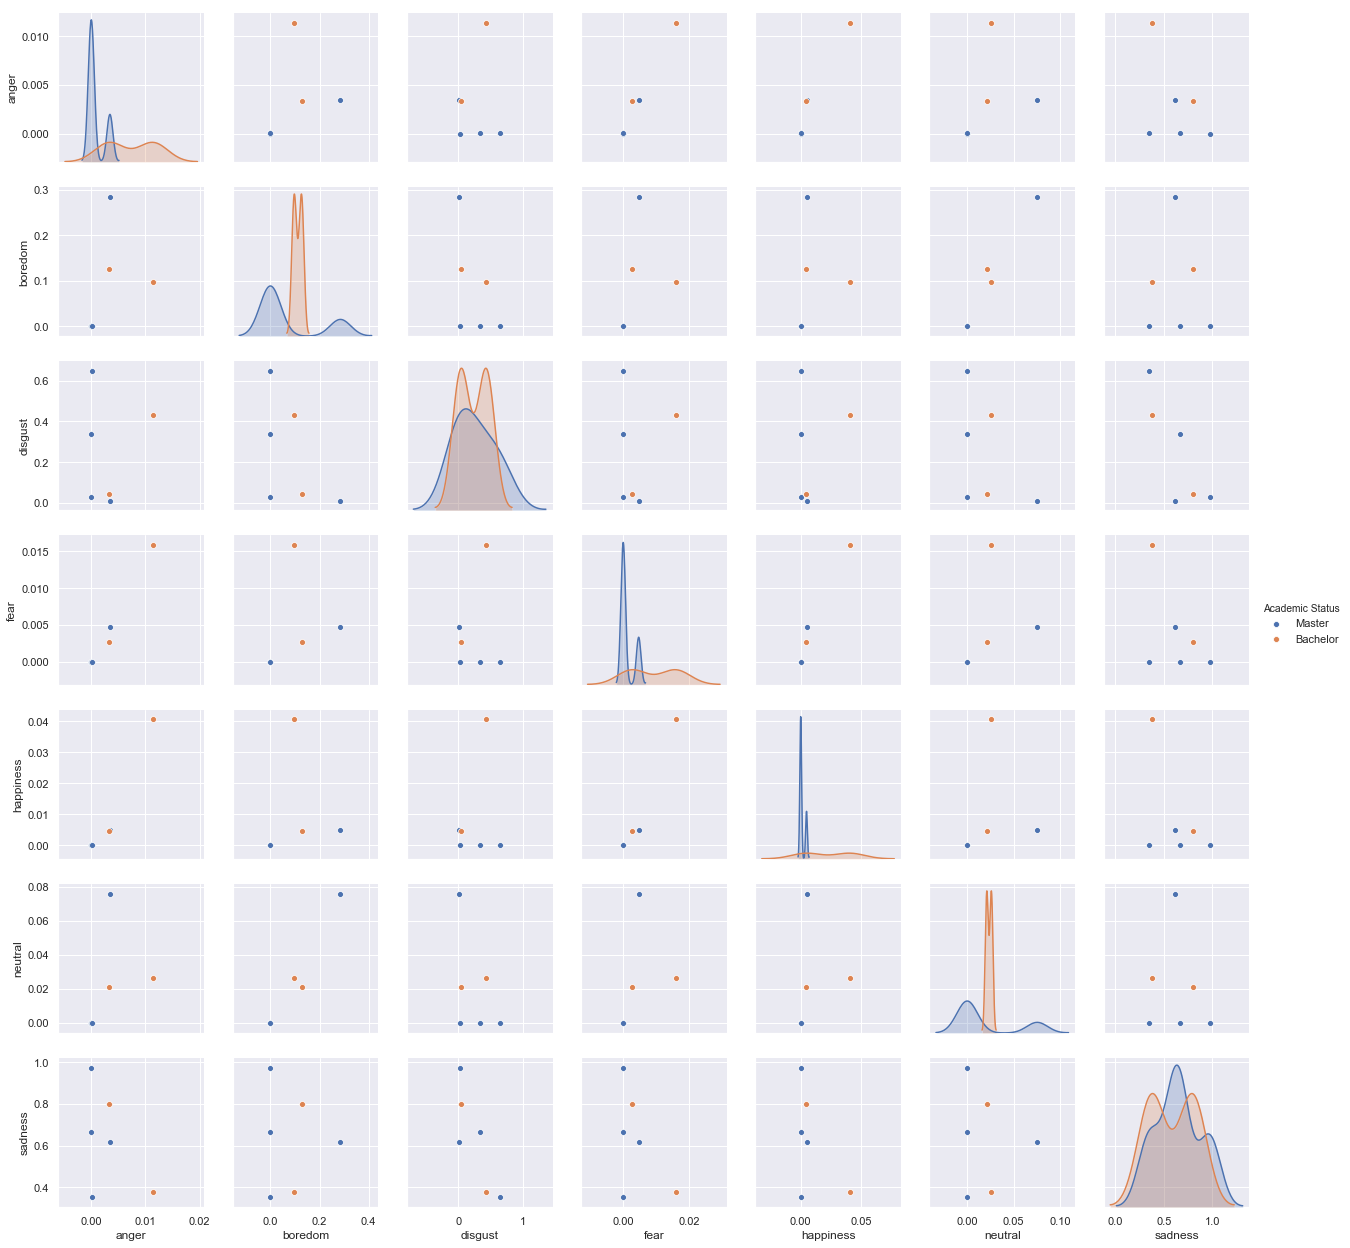

In [15]:
sns.pairplot(df_dis_emotion_aca, hue = "Academic Status")

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


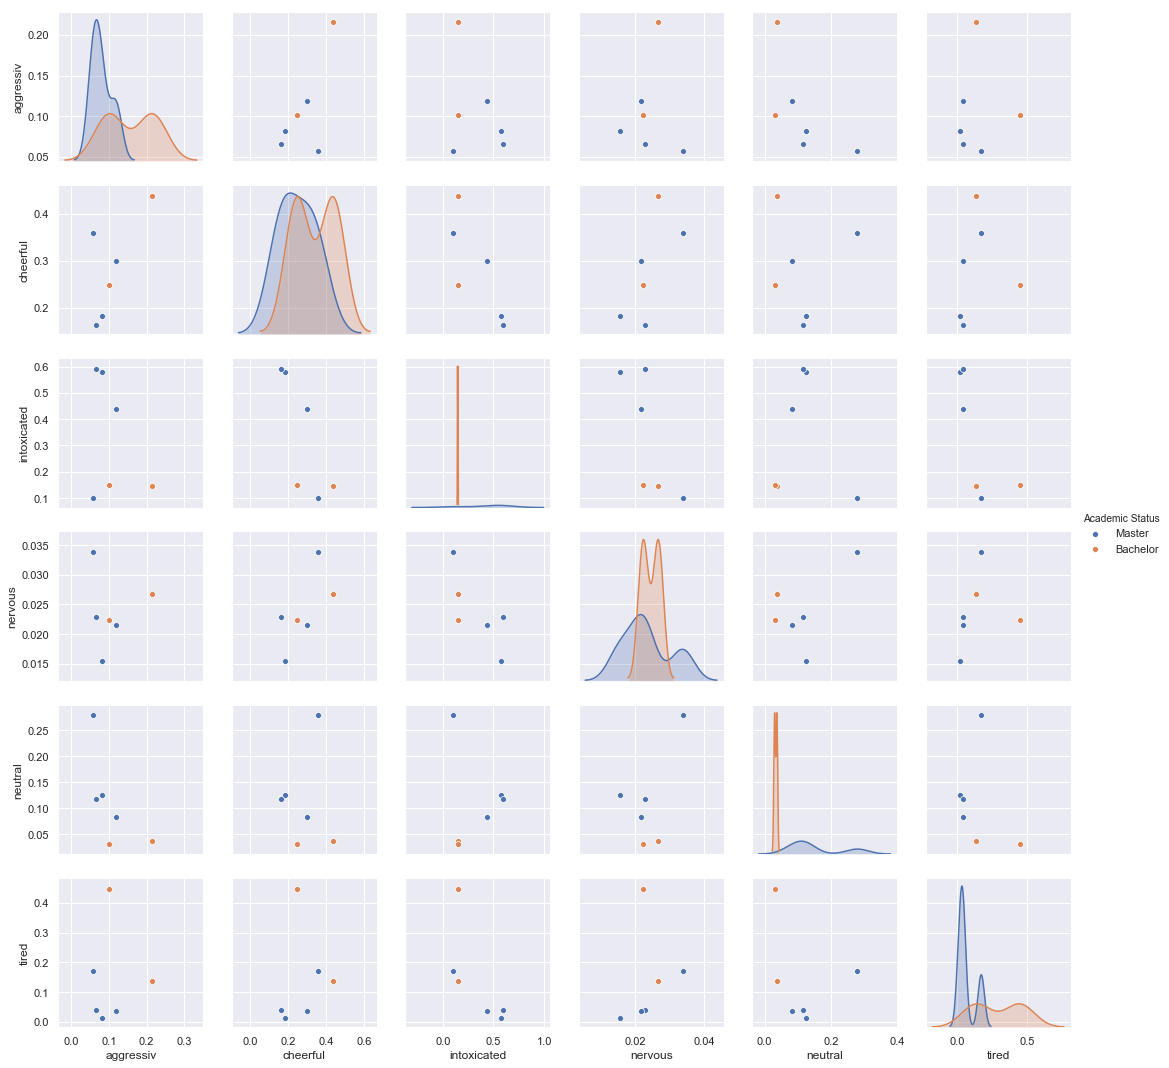

In [16]:
sns.pairplot(df_dis_affect_aca, hue = "Academic Status")

### Level of Interest and Academic Status

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


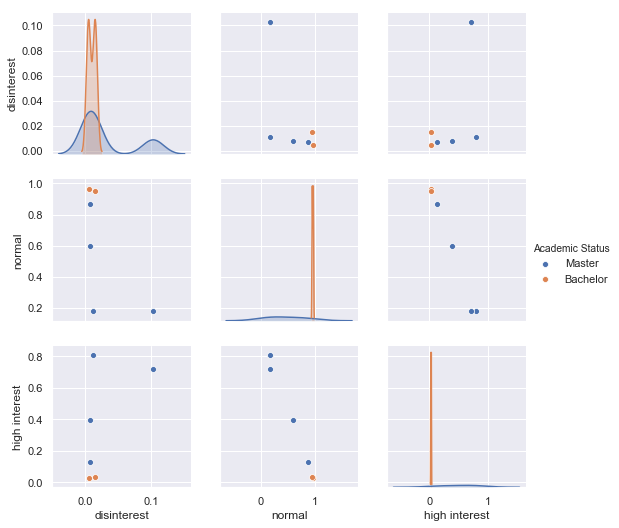

In [17]:
sns.pairplot(df_dis_loi_aca, hue = "Academic Status")

### Emotion and Age

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


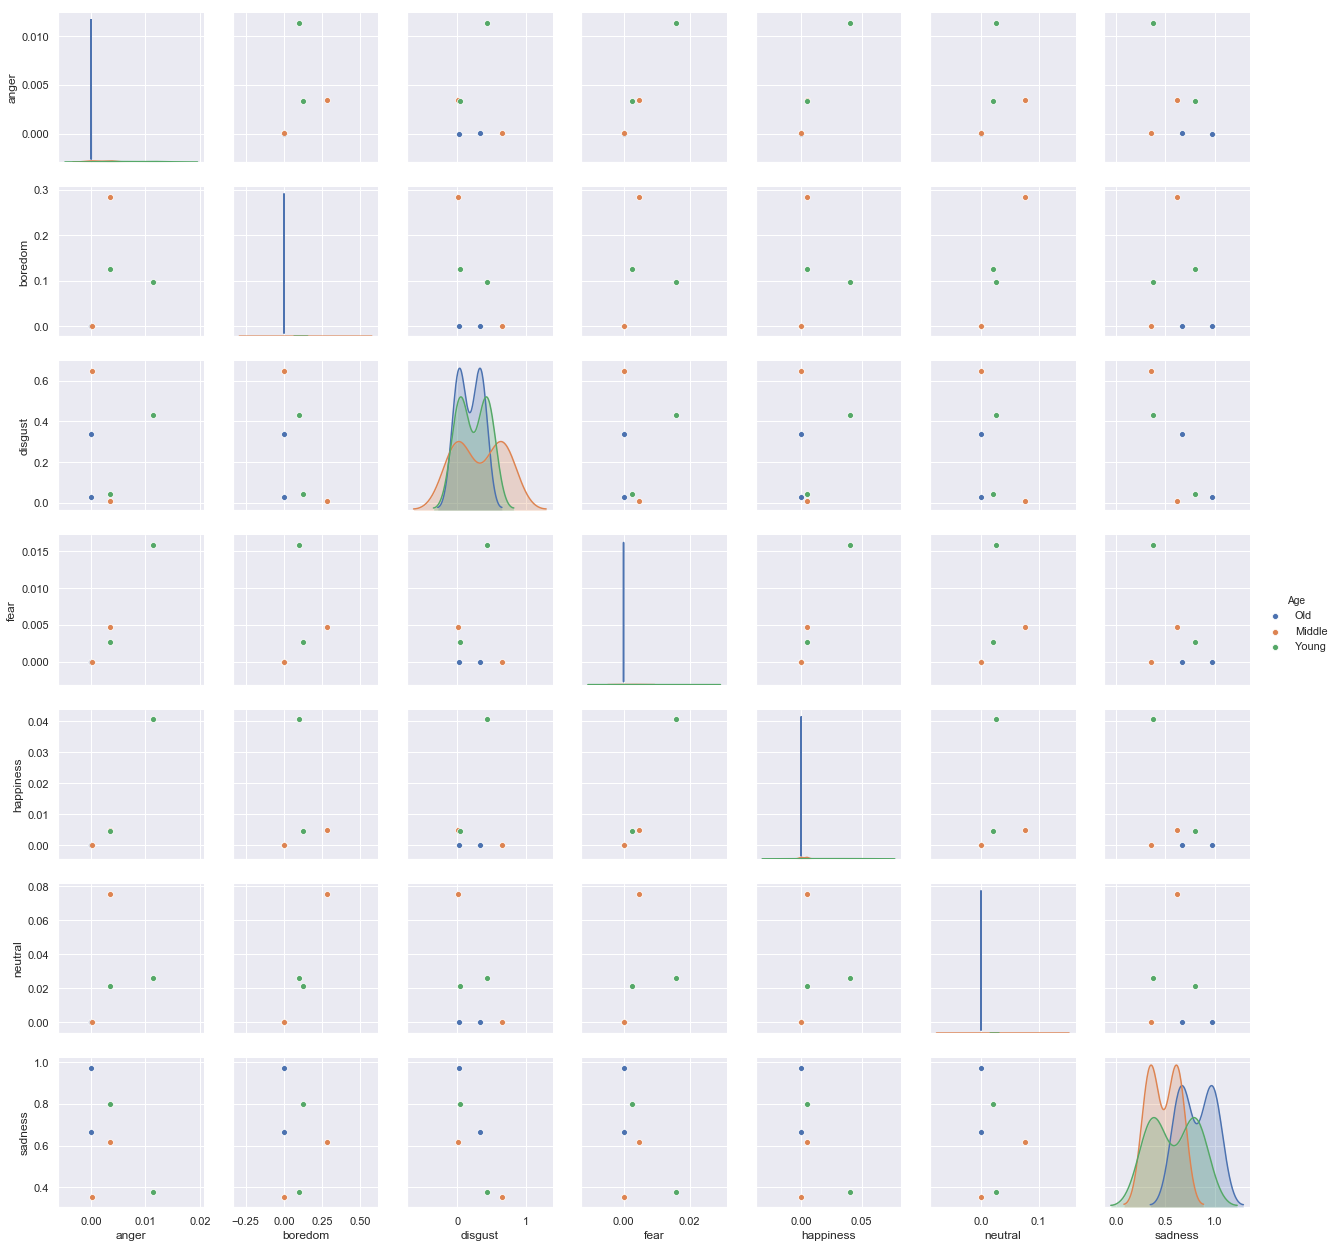

In [18]:
sns.pairplot(df_dis_emotion_age, hue = "Age")

### Affect and Age

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


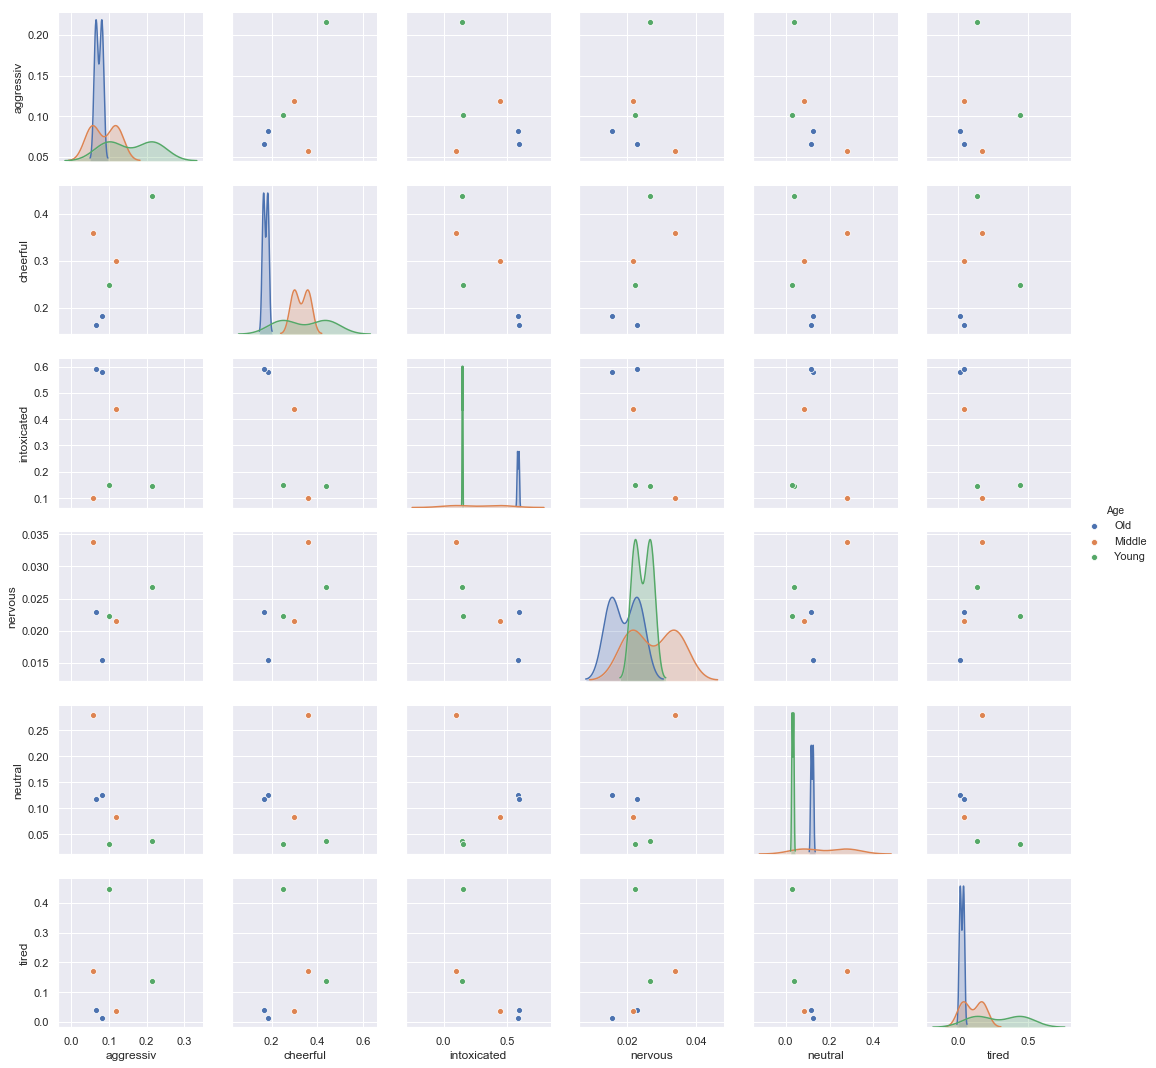

In [19]:
sns.pairplot(df_dis_affect_age, hue = "Age")

### Level of Interest and Age

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


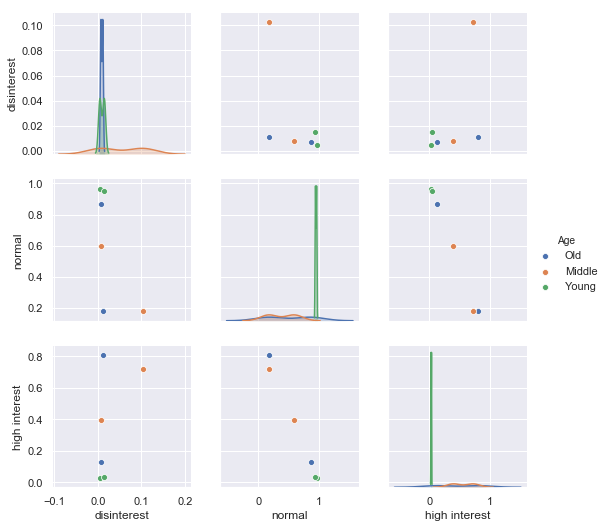

In [20]:
sns.pairplot(df_dis_loi_age, hue = "Age")